<a href="https://colab.research.google.com/github/emiljoswin/fastai-experiments2/blob/master/1_1_pets_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experiment Name: Pet Breed classification.   
Data source: https://www.robots.ox.ac.uk/~vgg/data/pets/

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
torch.cuda.get_device_name(0) # Find more specifications of the card

'Tesla K80'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
base_data_path  = '/content/drive/My Drive/fastai_data_real/' 
zip_path    = '/content/data/pets.tgz' 

### Download the data - if not already done so

In [0]:
!ls {base_data_path}

pets.tgz


In [0]:
!mkdir -p /content/data/

In [0]:
zip_path = download_data(URLs.PETS, zip_path); zip_path

In [0]:
!ls {zip_path}

In [0]:
!cp {zip_path} {data_path_in_google_drive}
!ls {data_path_in_google_drive}

In [0]:
!ls {base_data_path}

pets.tgz


### Copy from drive and unzip here

In [0]:
base_data_path = '/content/drive/My\ Drive/fastai_data_real'

In [0]:
zip_path = Path(base_data_path + '/pets.tgz')

In [0]:
!ls -a {zip_path}

'/content/drive/My Drive/fastai_data_real/pets.tgz'


In [0]:
! mkdir -p /content/data/
! tar -xzf {zip_path} -C /content/data #use -xvzf for verbose

In [0]:
!ls /content/data

oxford-iiit-pet  train	train-jpg.tar.7z  train_v2.csv.zip


### Start loading data

In [0]:
path = Path('/content/data/oxford-iiit-pet/')
path.ls()

[PosixPath('/content/data/oxford-iiit-pet/annotations'),
 PosixPath('/content/data/oxford-iiit-pet/images')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [0]:
fnames = get_image_files(path_img)

In [0]:
fnames[:3]

[PosixPath('/content/data/oxford-iiit-pet/images/saint_bernard_15.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/Siamese_83.jpg'),
 PosixPath('/content/data/oxford-iiit-pet/images/wheaten_terrier_135.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
%time data = ImageDataBunch.from_name_re(path_img, fnames, pat, bs=64, ds_tfms=get_transforms(), size=224)
%time data = data.normalize(imagenet_stats)

CPU times: user 1.12 s, sys: 62.1 ms, total: 1.19 s
Wall time: 1.22 s
CPU times: user 139 µs, sys: 21 µs, total: 160 µs
Wall time: 151 µs


CPU times: user 2.59 s, sys: 1.1 s, total: 3.69 s
Wall time: 7.06 s


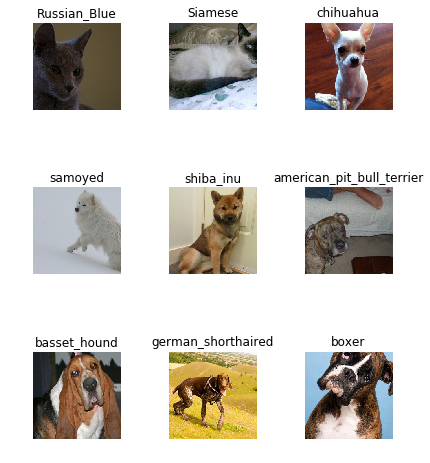

In [0]:
%%time 
data.show_batch(rows=3, figsize=(6,7))

In [0]:
s = data.train_ds.y[0]; s

Category saint_bernard

In [0]:
s.data # So, this is not one-hot-encoded

30

### Create Resnet34 Learner and run the frozen layer

In [0]:
accuracy??

In [0]:
learn34 = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 114463473.47it/s]


In [0]:
learn34.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn34.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.372098,0.318506,0.088633,01:17
1,0.579731,0.233494,0.077131,01:17
2,0.357308,0.196689,0.062923,01:17
3,0.268989,0.182726,0.061570,01:17


In [0]:
learn34.save('/content/models/model-1')

### Interpretation of Data

In [0]:
interp = ClassificationInterpretation.from_learner(learn34)

losses, idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

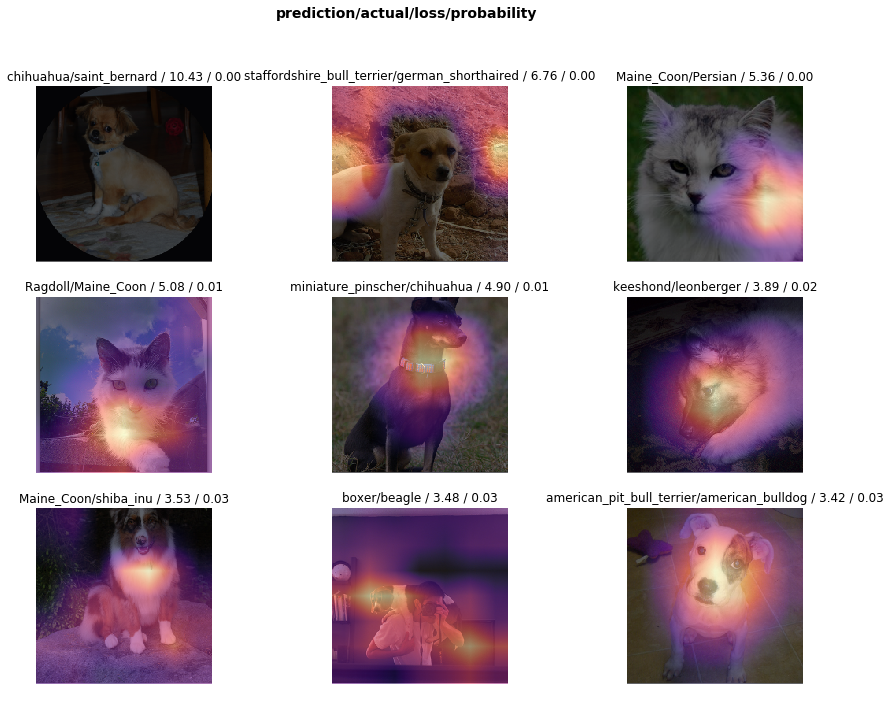

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

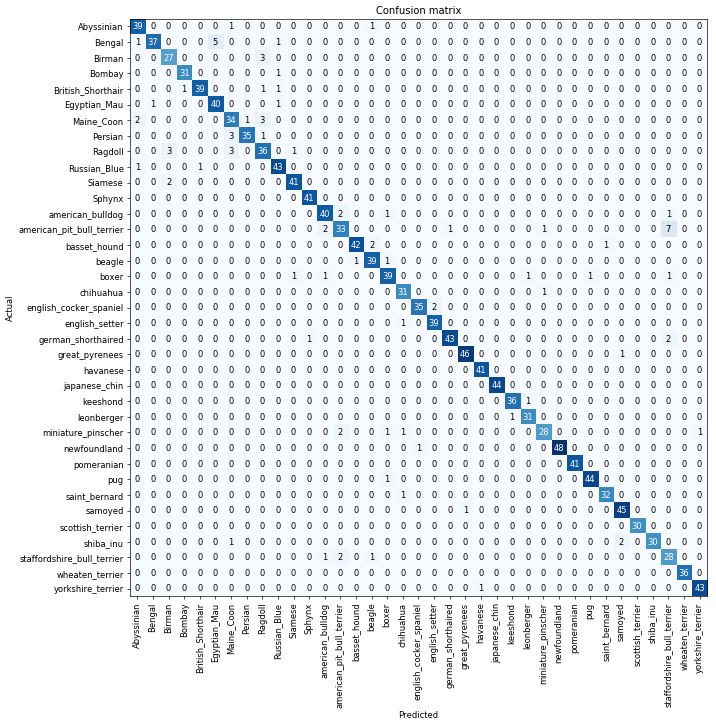

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Unfreeze and find a good learning rate

In [0]:
learn34.load('/content/models/model-1');

In [0]:
learn34.lr_find() # Remember - this is done after initial fit.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


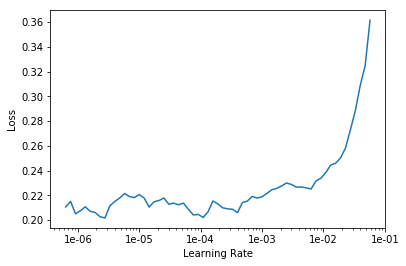

In [0]:
learn34.recorder.plot()

In [0]:
learn34.unfreeze()
learn34.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.308028,0.257137,0.087280,01:46
1,0.221119,0.189681,0.063599,01:47


### My experiments

In [0]:
learn34.load('/content/models/model-1');
learn34.unfreeze()
learn34.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.242638,0.181443,0.054127,01:46
1,0.207776,0.176910,0.055480,01:47


In [0]:
learn34.load('/content/models/model-1');
learn34.unfreeze()
learn34.fit_one_cycle(2, 1e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.226447,0.188406,0.054804,01:46
1,0.218939,0.186936,0.052097,01:46


In [0]:
learn34.load('/content/models/model-1');
learn34.unfreeze()
learn34.fit_one_cycle(4, 1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.235635,0.181096,0.051421,01:45
1,0.223423,0.175570,0.054127,01:46
2,0.201331,0.169523,0.051421,01:47
3,0.184316,0.169639,0.050068,01:48


### Resnet 50

In [0]:
%%time
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=32)
data = data.normalize(imagenet_stats)

CPU times: user 826 ms, sys: 25.7 ms, total: 852 ms
Wall time: 857 ms


In [0]:
learn50 = cnn_learner(data, models.resnet50, metrics=error_rate)

In [0]:
learn50.fit_one_cycle(4) 
# For small batchsize you need more epochs. 
# Each batchsize is basically averaging the gradients obtained by the samples in them.
# The smaller the batch size, the less accurate the value will be.
# Large batch size provide better value, but they need a lot of GPU to compute.

epoch,train_loss,valid_loss,error_rate,time
0,0.615417,0.240861,0.076455,03:23
1,0.362302,0.206946,0.072395,03:18
2,0.258161,0.166569,0.058863,03:18
3,0.160690,0.155189,0.054804,03:19


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 33 s, sys: 23.3 s, total: 56.3 s
Wall time: 1min 13s


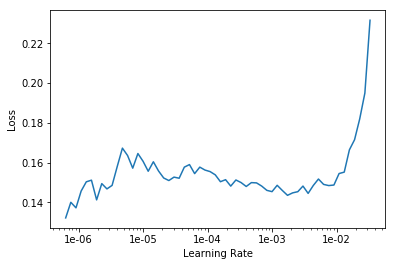

In [0]:
%%time
learn50.lr_find()
learn50.recorder.plot()

In [0]:
learn50.unfreeze()
learn50.fit_one_cycle(6, 1e-5) 
# Is there overfitting?

epoch,train_loss,valid_loss,error_rate,time
0,0.156098,0.152603,0.054804,04:22
1,0.125343,0.149009,0.052097,04:16
2,0.129139,0.143960,0.047361,04:18
3,0.097851,0.143687,0.048714,04:17
4,0.101863,0.141467,0.049391,04:17
5,0.086231,0.136624,0.047361,04:17


## Other formats

In [0]:
zip_path = '/content/data/mnist.tgz'

In [0]:
path = download_data(URLs.MNIST_SAMPLE, zip_path); path

PosixPath('/content/data/mnist.tgz')

In [0]:
!cp /content/data/mnist.tgz /content/drive/My\ Drive/fastai_data_real/

In [0]:
zip_path_base = '/content/drive/My\ Drive/fastai_data_real/mnist.tgz'

In [0]:
! tar -xzf {zip_path_base} -C /content/data #use -xvzf for verbose

In [0]:
!ls /content/data/mnist_sample

labels.csv  train  valid


In [0]:
!ls /content/data/mnist_sample/train

3  7


In [0]:
doc(ImageDataBunch.from_folder)

### CASE - I

In [0]:
# CASE-I - ImageNet Model


# If you need to load the train and valid directly from folder
# where folder name is the label eg: folder 3 contains datasets with
# label 3, do the following
path = '/content/data/mnist_sample'

#Note the flip transform
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

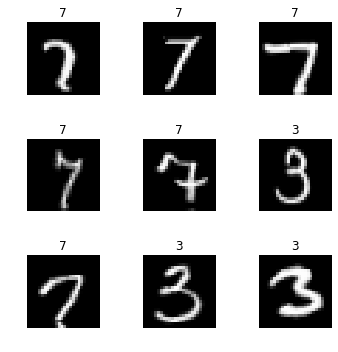

In [0]:
data.show_batch(rows=3, figsize=(5,5))

### CASE-II

In [0]:
# CASE-II

# If labels are given in the form of labels.csv 
# filename, label

!head -5 /content/data/mnist_sample/labels.csv

name,label
train/3/7463.png,0
train/3/21102.png,0
train/3/31559.png,0
train/3/46882.png,0


In [0]:
print('path is', path)
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

path is /content/data/mnist_sample


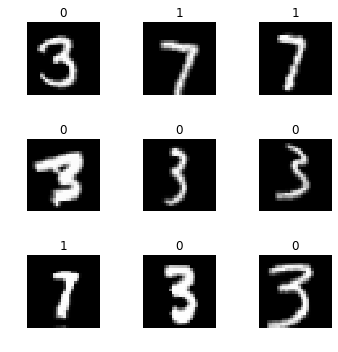

In [0]:
data.show_batch(rows=3, figsize=(5,5))

#Note that the labels say whether a sample is 7(1) or not(0).

### CASE-III

In [0]:
df = pd.read_csv('/content/data/mnist_sample/labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
path = Path('/content/data/mnist_sample/')

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/content/data/mnist_sample/train/3/7463.png'),
 PosixPath('/content/data/mnist_sample/train/3/21102.png')]

In [0]:
import re
pat = r"(.*)(\d)/(\d+).png$"; pat;
print("full", str(fn_paths[0]))
m = re.match(pat, str(fn_paths[0]))
print("1", m.group())
print("2", m.group(1))
print("3", m.group(2))
print("4", m.group(3))

full /content/data/mnist_sample/train/3/7463.png
1 /content/data/mnist_sample/train/3/7463.png
2 /content/data/mnist_sample/train/
3 3
4 7463


In [0]:
# Not sure why this works. It definitely doesnt work for normal regex
pat = r"/(\d)/\d+\.png$"; pat

'/(\\d)/\\d+\\.png$'

In [0]:
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)

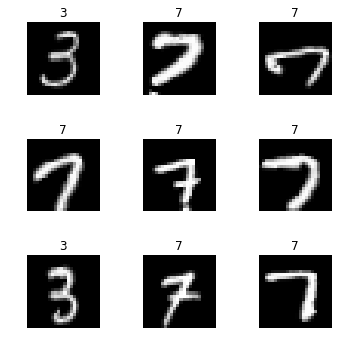

In [0]:
data.show_batch(rows=3, figsize=(5,5))

### CASE - IV


In [0]:
# If you want to create labels directly from the filenames

data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

### CASE-V

In [0]:
# Pass labels directly in the order of files
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
print('labels', labels[:5], fn_paths[:5])
print('labels', labels[-5], fn_paths[-5])


data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

labels ['3', '3', '3', '3', '3'] [PosixPath('/content/data/mnist_sample/train/3/7463.png'), PosixPath('/content/data/mnist_sample/train/3/21102.png'), PosixPath('/content/data/mnist_sample/train/3/31559.png'), PosixPath('/content/data/mnist_sample/train/3/46882.png'), PosixPath('/content/data/mnist_sample/train/3/26209.png')]
labels 7 /content/data/mnist_sample/valid/7/1321.png


['3', '7']

### Iterate over dataset

In [0]:
print(len(data.train_dl)); 
print(len(data.valid_dl));

180
46


In [0]:
# for x, y, in iter(data.train_dl): 
#   print(x, y)